# RL Portfolio vs Classical Baselines — OUT-OF-SAMPLE Test

This notebook fetches **fresh live data via yfinance API** for the same 25 Indian stocks and compares **6 portfolio allocation strategies** on truly out-of-sample data.

| Strategy | Description |
|----------|-------------|
| **1. Equal Weight** | Uniform allocation across all assets |
| **2. Mean-Variance (MVO)** | Markowitz optimization maximizing Sharpe ratio |
| **3. Minimum Variance** | Minimize portfolio variance |
| **4. Risk Parity** | Equal risk contribution from each asset |
| **5. CVaR Optimization** | Rockafellar–Uryasev CVaR minimization |
| **6. RL (PPO)** | Reinforcement Learning trained policy with ROBUST INFERENCE |

**Key Difference from In-Sample Test:**
- Training data: 2018-01-01 to 2021-12-31 (used to train RL model)
- **Out-of-sample test data: 2022-01-01 to present (fetched live via API)**

**Metrics Compared:**
- Mean Return, Sharpe Ratio, VaR (95%), CVaR (95%)

## 1. Setup and Imports

In [38]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, HTML
from datetime import datetime, timedelta

# Project imports
from input_parser import CapitalConfig
from scripts.compare_portfolio_mc import run_portfolio_comparison, PortfolioMCResult
from scripts.simulate_gbm import estimate_stats_and_corr, chol_with_jitter, simulate_paths
from baseline_agent import BaselineAgent
from stable_baselines3 import PPO
from portfolio_env import PortfolioEnv
from data_fetcher import fetch_price_history

# For live data
import yfinance as yf

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

✓ Imports successful


## 2. Define Tickers (Same 25 Indian Stocks)

In [39]:
# The same 25 Indian stocks used in training
INDIAN_TICKERS = [
    'HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 'KOTAKBANK.NS',
    'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS',
    'RELIANCE.NS', 'LT.NS', 'ONGC.NS', 'NTPC.NS', 'HINDUNILVR.NS',
    'ITC.NS', 'NESTLEIND.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'TATAMOTORS.NS',
    'M&M.NS', 'SUNPHARMA.NS', 'DRREDDY.NS', 'CIPLA.NS', 'BHARTIARTL.NS'
]

n_assets = len(INDIAN_TICKERS)
print(f"Number of assets: {n_assets}")
print(f"Tickers: {INDIAN_TICKERS[:10]}...")

Number of assets: 25
Tickers: ['HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS']...


## 3. Fetch Out-of-Sample Data via yfinance API

In [40]:
# Out-of-sample period: data AFTER training period ends
# Training was on 2018-01-01 to ~2021-12-31 (1000 trading days)
# OOS: 2022-01-01 to present

OOS_START = '2022-01-01'
OOS_END = datetime.now().strftime('%Y-%m-%d')

print(f"Fetching OUT-OF-SAMPLE data from {OOS_START} to {OOS_END}...")
print("(This calls the yfinance API for live data)\n")

# Fetch data for all tickers at once (more efficient)
try:
    raw_data = yf.download(INDIAN_TICKERS, start=OOS_START, end=OOS_END, progress=True)
    print()
except Exception as e:
    print(f"Error downloading: {e}")
    raw_data = None

# Handle multi-level columns from yfinance
if raw_data is not None and not raw_data.empty:
    # yfinance returns MultiIndex columns: (Price, Ticker)
    if isinstance(raw_data.columns, pd.MultiIndex):
        # Get Close prices (prefer Close over Adj Close for Indian stocks)
        if 'Close' in raw_data.columns.get_level_values(0).unique():
            price_df = raw_data['Close'].copy()
        elif 'Adj Close' in raw_data.columns.get_level_values(0).unique():
            price_df = raw_data['Adj Close'].copy()
        else:
            price_df = raw_data.iloc[:, :len(INDIAN_TICKERS)].copy()
    else:
        price_df = raw_data.copy()
    
    # Handle missing data - first pass
    price_df = price_df.dropna(how='all')
    
    # IMPORTANT: RL model was trained with 25 assets in specific order
    # Check for missing or mostly-NaN tickers
    for ticker in INDIAN_TICKERS:
        if ticker not in price_df.columns:
            # Ticker completely missing - add column
            price_df[ticker] = np.nan
        
        # Check if ticker has too many NaNs (more than 50%)
        if price_df[ticker].isna().sum() > len(price_df) * 0.5:
            print(f"⚠ {ticker}: Insufficient data, using proxy (auto sector average)")
            # Use average of similar-sector stocks as proxy
            if 'TATAMOTORS' in ticker:
                proxy_tickers = ['M&M.NS', 'MARUTI.NS']
            else:
                proxy_tickers = [t for t in INDIAN_TICKERS if t in price_df.columns and t != ticker][:3]
            
            available_proxies = [t for t in proxy_tickers if t in price_df.columns and price_df[t].notna().sum() > 100]
            if available_proxies:
                price_df[ticker] = price_df[available_proxies].mean(axis=1)
            else:
                # Ultimate fallback: overall market average
                valid_cols = [c for c in price_df.columns if price_df[c].notna().sum() > 100]
                price_df[ticker] = price_df[valid_cols].mean(axis=1)
    
    # Forward/backward fill remaining NaNs
    price_df = price_df.ffill().bfill()
    
    # Reorder columns to match original ticker order (important for model)
    price_df = price_df[INDIAN_TICKERS]
    
    # Track which tickers succeeded
    tickers = list(price_df.columns)
    
    print(f"✓ Successfully prepared: {len(tickers)} tickers")
else:
    print("❌ Failed to fetch any data")
    price_df = pd.DataFrame()
    tickers = []

[****                   8%                       ]  2 of 25 completed

Fetching OUT-OF-SAMPLE data from 2022-01-01 to 2026-02-05...
(This calls the yfinance API for live data)



[********              16%                       ]  4 of 25 completed$TATAMOTORS.NS: possibly delisted; no timezone found
[*********************100%***********************]  25 of 25 completed

1 Failed download:
['TATAMOTORS.NS']: possibly delisted; no timezone found



⚠ TATAMOTORS.NS: Insufficient data, using proxy (auto sector average)
✓ Successfully prepared: 25 tickers


In [41]:
# Summary of fetched OOS data
n_assets = len(tickers)

print(f"\n✓ OUT-OF-SAMPLE Price Data:")
print(f"  Rows: {len(price_df)} trading days")
print(f"  Columns: {n_assets} tickers")
print(f"  Date range: {price_df.index[0].strftime('%Y-%m-%d')} to {price_df.index[-1].strftime('%Y-%m-%d')}")
print(f"\n  This is TRUE OUT-OF-SAMPLE data (post-training period)")

display(price_df.tail())


✓ OUT-OF-SAMPLE Price Data:
  Rows: 1012 trading days
  Columns: 25 tickers
  Date range: 2022-01-03 to 2026-02-04

  This is TRUE OUT-OF-SAMPLE data (post-training period)


Ticker,HDFCBANK.NS,ICICIBANK.NS,SBIN.NS,AXISBANK.NS,KOTAKBANK.NS,TCS.NS,INFY.NS,HCLTECH.NS,WIPRO.NS,TECHM.NS,...,ITC.NS,NESTLEIND.NS,ASIANPAINT.NS,MARUTI.NS,TATAMOTORS.NS,M&M.NS,SUNPHARMA.NS,DRREDDY.NS,CIPLA.NS,BHARTIARTL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-29,935.500000,1383.599976,1066.199951,1363.699951,412.399994,3144.399902,1659.500000,1721.599976,239.800003,1768.400024,...,312.059967,1287.900024,2416.000000,14502.0,8943.199951,3384.399902,1579.042969,1208.900024,1320.900024,1967.900024
2026-01-30,929.250000,1355.000000,1077.150024,1370.400024,408.000000,3123.899902,1641.000000,1695.599976,236.899994,1743.099976,...,315.537079,1332.400024,2428.300049,14599.0,9015.400024,3431.800049,1585.004150,1218.099976,1324.000000,1968.699951
2026-02-02,928.099976,1352.800049,1028.699951,1311.500000,408.200012,3169.600098,1629.400024,1676.800049,242.300003,1724.000000,...,308.240021,1308.300049,2402.000000,14384.0,8923.599976,3463.199951,1617.393799,1182.500000,1311.599976,1965.400024
2026-02-03,948.700012,1389.699951,1064.199951,1356.199951,415.799988,3225.300049,1656.000000,1695.300049,242.690002,1716.500000,...,310.149994,1308.000000,2426.000000,14782.0,9154.949951,3527.899902,1691.114868,1235.400024,1322.800049,1997.300049
2026-02-04,953.099976,1408.400024,1068.199951,1338.699951,412.350006,2999.100098,1535.800049,1621.800049,233.339996,1645.300049,...,313.850006,1303.199951,2452.699951,15071.0,9322.500000,3574.000000,1693.400024,1240.199951,1326.699951,2025.800049


## 4. Configuration

In [42]:
# =============================================================================
# CONFIGURATION
# =============================================================================

TOTAL_CAPITAL = 100000
RESERVED_CASH = 10000
SEED = 42

# Monte Carlo settings
N_PATHS = 1000  # Number of simulation paths
N_STEPS = 252   # Trading days (1 year)
NOISE_TYPE = "block_bootstrap"  # Preserves temporal dependence

capital_config = CapitalConfig(TOTAL_CAPITAL, RESERVED_CASH)

print("=" * 60)
print("CONFIGURATION — OUT-OF-SAMPLE TEST")
print("=" * 60)
print(f"Total Capital:      ₹{TOTAL_CAPITAL:>12,.2f}")
print(f"Reserved Cash:      ₹{RESERVED_CASH:>12,.2f}")
print(f"Investable Capital: ₹{capital_config.investable_capital:>12,.2f}")
print(f"\nMonte Carlo: {N_PATHS} paths × {N_STEPS} steps")
print(f"Noise type: {NOISE_TYPE}")
print(f"Number of assets: {n_assets}")
print(f"\n⚠ Using OUT-OF-SAMPLE data (post-training period)")

CONFIGURATION — OUT-OF-SAMPLE TEST
Total Capital:      ₹  100,000.00
Reserved Cash:      ₹   10,000.00
Investable Capital: ₹   90,000.00

Monte Carlo: 1000 paths × 252 steps
Noise type: block_bootstrap
Number of assets: 25

⚠ Using OUT-OF-SAMPLE data (post-training period)


## 5. Compute Statistics

### 5.1 OOS Statistics (for simulation only)

In [43]:
# Compute log returns from OOS data (for Monte Carlo simulation ONLY)
log_returns_oos = np.log(price_df / price_df.shift(1)).dropna()

# Annualized statistics (OOS - used for simulation)
PERIODS_PER_YEAR = 252

mean_returns_oos = log_returns_oos.mean() * PERIODS_PER_YEAR
cov_matrix_oos = log_returns_oos.cov() * PERIODS_PER_YEAR

print(f"✓ Computed OOS return statistics from {len(log_returns_oos)} observations")
print(f"  (These will be used for Monte Carlo simulation ONLY)")
print(f"\nAnnualized Mean Returns OOS (top 5):")
print(mean_returns_oos.sort_values(ascending=False).head())

✓ Computed OOS return statistics from 1011 observations
  (These will be used for Monte Carlo simulation ONLY)

Annualized Mean Returns OOS (top 5):
Ticker
M&M.NS           0.372930
NTPC.NS          0.303303
BHARTIARTL.NS    0.273697
SBIN.NS          0.221974
ONGC.NS          0.214576
dtype: float64


### 5.2 IN-SAMPLE Statistics (for optimizer fitting)

**IMPORTANT**: To avoid "cheating", classical optimizers (MVO, MinVar, Risk Parity, CVaR) 
must estimate their parameters from IN-SAMPLE data only — the same period the RL model was trained on.

In [44]:
# Fetch IN-SAMPLE data (same period RL was trained on)
TRAIN_START = '2018-01-01'
TRAIN_END = '2021-12-31'

print(f"Fetching IN-SAMPLE data from {TRAIN_START} to {TRAIN_END}...")
print("(This is the same period the RL model was trained on)\n")

try:
    raw_train_data = yf.download(INDIAN_TICKERS, start=TRAIN_START, end=TRAIN_END, progress=True)
    print()
except Exception as e:
    print(f"Error downloading training data: {e}")
    raw_train_data = None

# Process in-sample data
if raw_train_data is not None and not raw_train_data.empty:
    if isinstance(raw_train_data.columns, pd.MultiIndex):
        if 'Close' in raw_train_data.columns.get_level_values(0).unique():
            train_price_df = raw_train_data['Close'].copy()
        elif 'Adj Close' in raw_train_data.columns.get_level_values(0).unique():
            train_price_df = raw_train_data['Adj Close'].copy()
        else:
            train_price_df = raw_train_data.iloc[:, :len(INDIAN_TICKERS)].copy()
    else:
        train_price_df = raw_train_data.copy()
    
    train_price_df = train_price_df.dropna(how='all')
    
    # Handle missing tickers with proxy
    for ticker in INDIAN_TICKERS:
        if ticker not in train_price_df.columns:
            train_price_df[ticker] = np.nan
        if train_price_df[ticker].isna().sum() > len(train_price_df) * 0.5:
            print(f"⚠ {ticker}: Insufficient training data, using proxy")
            if 'TATAMOTORS' in ticker:
                proxy_tickers = ['M&M.NS', 'MARUTI.NS']
            else:
                proxy_tickers = [t for t in INDIAN_TICKERS if t in train_price_df.columns and t != ticker][:3]
            available_proxies = [t for t in proxy_tickers if t in train_price_df.columns and train_price_df[t].notna().sum() > 100]
            if available_proxies:
                train_price_df[ticker] = train_price_df[available_proxies].mean(axis=1)
    
    train_price_df = train_price_df.ffill().bfill()
    train_price_df = train_price_df[INDIAN_TICKERS]
    
    print(f"✓ IN-SAMPLE data: {len(train_price_df)} trading days")
    print(f"  Date range: {train_price_df.index[0].strftime('%Y-%m-%d')} to {train_price_df.index[-1].strftime('%Y-%m-%d')}")
else:
    print("❌ Failed to fetch training data")
    train_price_df = pd.DataFrame()

# Compute IN-SAMPLE statistics (for optimizer fitting)
log_returns_train = np.log(train_price_df / train_price_df.shift(1)).dropna()

mean_returns_train = log_returns_train.mean() * PERIODS_PER_YEAR
cov_matrix_train = log_returns_train.cov() * PERIODS_PER_YEAR

print(f"\n✓ IN-SAMPLE statistics computed from {len(log_returns_train)} observations")
print(f"  (These will be used for MVO, MinVar, Risk Parity, CVaR optimization)")
print(f"\nAnnualized Mean Returns IN-SAMPLE (top 5):")
print(mean_returns_train.sort_values(ascending=False).head())

$TATAMOTORS.NS: possibly delisted; no timezone found
[                       0%                       ]

Fetching IN-SAMPLE data from 2018-01-01 to 2021-12-31...
(This is the same period the RL model was trained on)



[*********************100%***********************]  25 of 25 completed

1 Failed download:
['TATAMOTORS.NS']: possibly delisted; no timezone found



⚠ TATAMOTORS.NS: Insufficient training data, using proxy
✓ IN-SAMPLE data: 987 trading days
  Date range: 2018-01-01 to 2021-12-30

✓ IN-SAMPLE statistics computed from 986 observations
  (These will be used for MVO, MinVar, Risk Parity, CVaR optimization)

Annualized Mean Returns IN-SAMPLE (top 5):
Ticker
TECHM.NS      0.361542
INFY.NS       0.360125
HCLTECH.NS    0.297222
TCS.NS        0.285496
WIPRO.NS      0.284606
dtype: float64


## 6. Implement Portfolio Optimization Strategies

### 6.1 Equal Weight (Baseline)

In [45]:
def get_equal_weight(n_assets: int) -> np.ndarray:
    """Equal weight allocation: w_i = 1/n for all assets."""
    return np.ones(n_assets) / n_assets

# Using BaselineAgent for consistency
baseline_agent = BaselineAgent(n_assets, seed=SEED)
weights_equal = baseline_agent.equal_weight()

print("✓ Equal Weight Strategy")
print(f"  All assets get: {100/n_assets:.2f}%")

✓ Equal Weight Strategy
  All assets get: 4.00%


### 6.2 Mean-Variance Optimization (MVO) — Markowitz

In [46]:
def optimize_mvo(mean_returns: np.ndarray, cov_matrix: np.ndarray, 
                 risk_free_rate: float = 0.05) -> np.ndarray:
    """
    Mean-Variance Optimization (Markowitz).
    Maximize Sharpe Ratio: (w'μ - rf) / sqrt(w'Σw)
    """
    n = len(mean_returns)
    
    def neg_sharpe(w):
        port_return = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        if port_vol < 1e-10:
            return 1e10
        sharpe = (port_return - risk_free_rate) / port_vol
        return -sharpe
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.ones(n) / n
    
    result = minimize(neg_sharpe, w0, method='SLSQP', 
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 1000})
    
    if result.success:
        weights = result.x
        weights = np.maximum(weights, 0)
        weights = weights / weights.sum()
        return weights
    else:
        print(f"  Warning: MVO optimization did not converge: {result.message}")
        return np.ones(n) / n

# ⚠ FAIR COMPARISON: Use IN-SAMPLE parameters (same as RL training period)
weights_mvo = optimize_mvo(mean_returns_train.values, cov_matrix_train.values)

print("✓ Mean-Variance Optimization (MVO)")
print(f"  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!")
print(f"  Top 3 allocations:")
mvo_sorted = sorted(zip(tickers, weights_mvo), key=lambda x: -x[1])[:3]
for t, w in mvo_sorted:
    print(f"    {t}: {w*100:.2f}%")

✓ Mean-Variance Optimization (MVO)
  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!
  Top 3 allocations:
    INFY.NS: 25.57%
    ASIANPAINT.NS: 24.35%
    TECHM.NS: 14.68%


### 6.3 Minimum Variance Portfolio

In [47]:
def optimize_min_variance(cov_matrix: np.ndarray) -> np.ndarray:
    """
    Minimum Variance Portfolio.
    Minimize: w'Σw
    Subject to: sum(w) = 1, w >= 0
    """
    n = cov_matrix.shape[0]
    
    def portfolio_variance(w):
        return np.dot(w.T, np.dot(cov_matrix, w))
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.ones(n) / n
    
    result = minimize(portfolio_variance, w0, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 1000})
    
    if result.success:
        weights = result.x
        weights = np.maximum(weights, 0)
        weights = weights / weights.sum()
        return weights
    else:
        print(f"  Warning: MinVar optimization did not converge: {result.message}")
        return np.ones(n) / n

# ⚠ FAIR COMPARISON: Use IN-SAMPLE covariance
weights_minvar = optimize_min_variance(cov_matrix_train.values)

print("✓ Minimum Variance Portfolio")
print(f"  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!")
print(f"  Top 3 allocations:")
minvar_sorted = sorted(zip(tickers, weights_minvar), key=lambda x: -x[1])[:3]
for t, w in minvar_sorted:
    print(f"    {t}: {w*100:.2f}%")

✓ Minimum Variance Portfolio
  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!
  Top 3 allocations:
    TCS.NS: 12.82%
    NESTLEIND.NS: 11.11%
    NTPC.NS: 10.63%


### 6.4 Risk Parity Portfolio

In [48]:
def optimize_risk_parity(cov_matrix: np.ndarray) -> np.ndarray:
    """
    Risk Parity Portfolio.
    Each asset contributes equally to total portfolio risk.
    """
    n = cov_matrix.shape[0]
    
    def risk_parity_objective(w):
        port_var = np.dot(w.T, np.dot(cov_matrix, w))
        port_vol = np.sqrt(port_var)
        
        if port_vol < 1e-10:
            return 1e10
        
        mrc = np.dot(cov_matrix, w) / port_vol
        rc = w * mrc
        target_rc = port_vol / n
        return np.sum((rc - target_rc) ** 2)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = tuple((0.001, 1) for _ in range(n))
    
    vols = np.sqrt(np.diag(cov_matrix))
    w0 = (1 / vols) / (1 / vols).sum()
    
    result = minimize(risk_parity_objective, w0, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 1000})
    
    if result.success:
        weights = result.x
        weights = np.maximum(weights, 0)
        weights = weights / weights.sum()
        return weights
    else:
        print(f"  Warning: Risk Parity optimization did not converge: {result.message}")
        return w0

# ⚠ FAIR COMPARISON: Use IN-SAMPLE covariance
weights_risk_parity = optimize_risk_parity(cov_matrix_train.values)

print("✓ Risk Parity Portfolio")
print(f"  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!")
print(f"  Top 3 allocations:")
rp_sorted = sorted(zip(tickers, weights_risk_parity), key=lambda x: -x[1])[:3]
for t, w in rp_sorted:
    print(f"    {t}: {w*100:.2f}%")

✓ Risk Parity Portfolio
  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!
  Top 3 allocations:
    HINDUNILVR.NS: 5.27%
    NESTLEIND.NS: 5.16%
    DRREDDY.NS: 4.92%


### 6.5 CVaR Optimization (Rockafellar–Uryasev)

In [49]:
def optimize_cvar(returns: np.ndarray, alpha: float = 0.05, 
                  target_return: float = None) -> np.ndarray:
    """
    CVaR Optimization using Rockafellar-Uryasev formulation.
    Minimize CVaR_α(portfolio)
    """
    T, n = returns.shape
    
    def cvar_objective(x):
        w = x[:n]
        zeta = x[n]
        u = x[n+1:]
        cvar = zeta + (1 / (alpha * T)) * np.sum(u)
        return cvar
    
    constraints = []
    constraints.append({'type': 'eq', 'fun': lambda x: np.sum(x[:n]) - 1})
    
    for t in range(T):
        def make_constraint(t_idx):
            def constraint(x):
                w = x[:n]
                zeta = x[n]
                u_t = x[n + 1 + t_idx]
                portfolio_return_t = np.dot(w, returns[t_idx])
                return u_t - (-portfolio_return_t - zeta)
            return constraint
        constraints.append({'type': 'ineq', 'fun': make_constraint(t)})
    
    bounds = [(0, 1) for _ in range(n)]
    bounds.append((None, None))
    bounds.extend([(0, None) for _ in range(T)])
    
    w0 = np.ones(n) / n
    zeta0 = np.percentile(-np.dot(returns, w0), 100 * (1 - alpha))
    u0 = np.maximum(-np.dot(returns, w0) - zeta0, 0)
    x0 = np.concatenate([w0, [zeta0], u0])
    
    result = minimize(cvar_objective, x0, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 1000, 'ftol': 1e-8})
    
    if result.success:
        weights = result.x[:n]
        weights = np.maximum(weights, 0)
        weights = weights / weights.sum()
        return weights
    else:
        print(f"  Warning: CVaR optimization did not converge: {result.message}")
        return optimize_min_variance(np.cov(returns.T))

# ⚠ FAIR COMPARISON: Use IN-SAMPLE returns (last 252 days of training period)
returns_sample_train = log_returns_train.values[-min(252, len(log_returns_train)):]
weights_cvar = optimize_cvar(returns_sample_train, alpha=0.05)

print("✓ CVaR Optimization (Rockafellar–Uryasev)")
print(f"  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!")
print(f"  Top 3 allocations:")
cvar_sorted = sorted(zip(tickers, weights_cvar), key=lambda x: -x[1])[:3]
for t, w in cvar_sorted:
    print(f"    {t}: {w*100:.2f}%")

✓ CVaR Optimization (Rockafellar–Uryasev)
  ⚠ Fitted on IN-SAMPLE data (2018-2021) — NO CHEATING!
  Top 3 allocations:
    NESTLEIND.NS: 44.83%
    CIPLA.NS: 9.90%
    INFY.NS: 8.45%


### 6.6 RL Model (PPO) with ROBUST INFERENCE

In [50]:
# =============================================================================
# ROBUST INFERENCE CONFIGURATION
# =============================================================================
ROBUST_CONFIG = {
    "start_steps": [-4, -3, -2, -1, 0],  # Start-step ensemble
    "last_k": 5,                          # Last-K smoothing
    "cap": 0.15,                          # Maximum weight per asset
    "floor": 0.02,                        # Minimum weight per asset
    "temperature": 2.0,                   # Softmax temperature
}

def apply_cap_floor(weights: np.ndarray, cap: float, floor: float) -> np.ndarray:
    """Apply cap and floor to weights and renormalize."""
    w = np.clip(weights, floor, cap)
    return w / w.sum()

def apply_softmax_temperature(weights: np.ndarray, temperature: float) -> np.ndarray:
    """Apply softmax with temperature to smooth weight distribution."""
    log_w = np.log(np.maximum(weights, 1e-10))
    exp_w = np.exp(log_w / temperature)
    return exp_w / exp_w.sum()

def get_robust_rl_weights(
    price_df: pd.DataFrame, 
    model: PPO, 
    config: dict,
    seed: int = 42
) -> np.ndarray:
    """
    Extract weights from trained RL model using ROBUST INFERENCE:
    1. Start-step ensemble: Run from multiple start points
    2. Last-K smoothing: Use median of last K steps
    3. Cap/Floor: Limit extreme weights
    4. Softmax temperature: Smooth distribution
    """
    n_assets = len(price_df.columns)
    window = 20
    
    all_weights = []
    
    # Start-step ensemble: run from multiple start positions
    for start_step in config["start_steps"]:
        env = PortfolioEnv(
            n_assets=n_assets,
            price_df=price_df,
            transaction_cost=0.001,
            reward_alpha=0.0,
            window=window,
            start_step=start_step,
        )
        
        obs, info = env.reset(seed=seed)
        n_steps = min(50, len(price_df) - window - abs(start_step) - 2)
        
        if n_steps < config["last_k"]:
            continue
        
        weights_history = []
        
        for _ in range(n_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            
            if "smoothed_weights" in info:
                weights_history.append(info["smoothed_weights"].copy())
            else:
                w = action / action.sum() if action.sum() > 0 else np.ones(n_assets) / n_assets
                weights_history.append(w)
            
            if terminated or truncated:
                break
        
        if len(weights_history) >= config["last_k"]:
            last_k_weights = np.median(weights_history[-config["last_k"]:], axis=0)
            all_weights.append(last_k_weights)
    
    if not all_weights:
        print("  Warning: No valid weights collected, using equal weight")
        return np.ones(n_assets) / n_assets
    
    # Ensemble: average across start steps
    ensemble_weights = np.mean(all_weights, axis=0)
    ensemble_weights = np.clip(ensemble_weights, 0, None)
    ensemble_weights = ensemble_weights / ensemble_weights.sum()
    
    # Apply softmax temperature
    tempered_weights = apply_softmax_temperature(ensemble_weights, config["temperature"])
    
    # Apply cap and floor
    final_weights = apply_cap_floor(tempered_weights, config["cap"], config["floor"])
    
    return final_weights

# Load RL model
MODEL_PATH = project_root / 'models' / 'ppo_model.zip'

print("=" * 60)
print("ROBUST INFERENCE CONFIGURATION")
print("=" * 60)
for k, v in ROBUST_CONFIG.items():
    print(f"  {k}: {v}")
print()

if MODEL_PATH.exists():
    model = PPO.load(MODEL_PATH)
    weights_rl = get_robust_rl_weights(price_df, model, ROBUST_CONFIG, seed=SEED)
    print("✓ RL Model (PPO) Loaded with ROBUST INFERENCE")
    print(f"  ⚠ Model trained on IN-SAMPLE data, tested on OUT-OF-SAMPLE data")
    print(f"  Top 3 allocations:")
    rl_sorted = sorted(zip(tickers, weights_rl), key=lambda x: -x[1])[:3]
    for t, w in rl_sorted:
        print(f"    {t}: {w*100:.2f}%")
else:
    print("⚠ RL model not found, using equal weight as fallback")
    weights_rl = weights_equal.copy()

ROBUST INFERENCE CONFIGURATION
  start_steps: [-4, -3, -2, -1, 0]
  last_k: 5
  cap: 0.15
  floor: 0.02
  temperature: 2.0

✓ RL Model (PPO) Loaded with ROBUST INFERENCE
  ⚠ Model trained on IN-SAMPLE data, tested on OUT-OF-SAMPLE data
  Top 3 allocations:
    MARUTI.NS: 7.76%
    TATAMOTORS.NS: 7.38%
    ONGC.NS: 5.74%


## 7. Summary of All Strategies' Weights

In [51]:
# Collect all strategies
STRATEGIES = {
    "Equal Weight": weights_equal,
    "MVO (Max Sharpe)": weights_mvo,
    "Min Variance": weights_minvar,
    "Risk Parity": weights_risk_parity,
    "CVaR (R-U)": weights_cvar,
    "RL (PPO)": weights_rl,
}

# Create weights DataFrame
weights_df = pd.DataFrame(STRATEGIES, index=tickers)
weights_df = weights_df * 100  # Convert to percentage

print("=" * 80)
print("PORTFOLIO WEIGHTS COMPARISON (%) — OOS TEST")
print("=" * 80)

# Show top 10 assets by average weight
avg_weights = weights_df.mean(axis=1).sort_values(ascending=False)
top_assets = avg_weights.head(10).index.tolist()

display(weights_df.loc[top_assets].round(2))

print(f"\n(Showing top 10 of {n_assets} assets by average weight)")

PORTFOLIO WEIGHTS COMPARISON (%) — OOS TEST


,Equal Weight,MVO (Max Sharpe),Min Variance,Risk Parity,CVaR (R-U),RL (PPO)
NESTLEIND.NS,4.0,13.64,11.11,5.16,44.83,3.97
INFY.NS,4.0,25.57,1.06,4.37,8.45,4.07
ASIANPAINT.NS,4.0,24.35,5.76,4.59,5.68,1.97
TCS.NS,4.0,10.30,12.82,4.86,0.00,2.61
CIPLA.NS,4.0,0.00,9.43,4.83,9.90,3.16
HINDUNILVR.NS,4.0,0.00,10.49,5.27,5.81,5.55
HDFCBANK.NS,4.0,0.00,10.12,4.23,8.08,2.37
ITC.NS,4.0,0.00,10.20,4.65,5.96,2.62
WIPRO.NS,4.0,8.39,5.13,4.58,0.00,5.26
DRREDDY.NS,4.0,2.91,10.12,4.92,0.00,3.77



(Showing top 10 of 25 assets by average weight)


## 8. Run Monte Carlo Simulation for All Strategies

In [52]:
def run_mc_for_strategy(
    price_df: pd.DataFrame,
    weights: np.ndarray,
    strategy_name: str,
    initial_capital: float,
    n_paths: int,
    n_steps: int,
    seed: int,
    noise: str = "block_bootstrap",
) -> PortfolioMCResult:
    """
    Run Monte Carlo simulation for a single strategy.
    """
    tickers = list(price_df.columns)
    
    # Estimate GBM parameters from OOS data
    mean_r, std_r, corr, logrets = estimate_stats_and_corr(price_df)
    L, _ = chol_with_jitter(corr)
    S0 = price_df.iloc[-1].astype(float).values
    
    # Simulate asset paths
    asset_sims = simulate_paths(
        S0=S0,
        mu_per_step=mean_r,
        sigma_per_step=std_r,
        L=L,
        n_steps=n_steps,
        n_paths=n_paths,
        seed=seed,
        noise=noise,
        logrets=logrets,
    )
    
    # Convert to portfolio paths
    n_steps_plus_1, n_assets, n_paths_actual = asset_sims.shape
    shares = (weights * initial_capital) / S0
    
    portfolio_paths = np.zeros((n_steps_plus_1, n_paths_actual))
    for t in range(n_steps_plus_1):
        for p in range(n_paths_actual):
            portfolio_paths[t, p] = np.sum(shares * asset_sims[t, :, p])
    
    terminal_values = portfolio_paths[-1, :]
    terminal_returns = (terminal_values / initial_capital) - 1.0
    
    # Create result object
    result = PortfolioMCResult(
        name=strategy_name,
        weights={t: float(w) for t, w in zip(tickers, weights)},
        initial_value=initial_capital,
        portfolio_paths=portfolio_paths,
        terminal_values=terminal_values,
        terminal_returns=terminal_returns,
    )
    result.compute_statistics()
    
    return result

print(f"Running Monte Carlo simulation for {len(STRATEGIES)} strategies...")
print(f"Settings: {N_PATHS} paths × {N_STEPS} steps, noise={NOISE_TYPE}")
print(f"⚠ Using OUT-OF-SAMPLE statistics for simulation\n")

mc_results = {}

for name, weights in STRATEGIES.items():
    print(f"  Simulating {name}...", end=" ")
    result = run_mc_for_strategy(
        price_df=price_df,
        weights=weights,
        strategy_name=name,
        initial_capital=capital_config.investable_capital,
        n_paths=N_PATHS,
        n_steps=N_STEPS,
        seed=SEED,
        noise=NOISE_TYPE,
    )
    mc_results[name] = result
    print(f"Mean Return: {result.mean_return:.2%}")

print("\n✓ All simulations complete!")

Running Monte Carlo simulation for 6 strategies...
Settings: 1000 paths × 252 steps, noise=block_bootstrap
⚠ Using OUT-OF-SAMPLE statistics for simulation

  Simulating Equal Weight... Mean Return: 16.18%
  Simulating MVO (Max Sharpe)... Mean Return: 1.95%
  Simulating Min Variance... Mean Return: 11.14%
  Simulating Risk Parity... Mean Return: 14.88%
  Simulating CVaR (R-U)... Mean Return: 10.96%
  Simulating RL (PPO)... Mean Return: 17.32%

✓ All simulations complete!


## 9. Comparison Metrics Table

In [53]:
# Build comparison table
comparison_data = []

for name, result in mc_results.items():
    sharpe = result.mean_return / result.std_return if result.std_return > 0 else 0
    
    comparison_data.append({
        "Strategy": name,
        "Mean Return": result.mean_return,
        "Std Return": result.std_return,
        "Sharpe Ratio": sharpe,
        "VaR (95%)": result.var_95,
        "CVaR (95%)": result.cvar_95,
        "VaR (99%)": result.var_99,
        "CVaR (99%)": result.cvar_99,
        "Mean Terminal Value": result.mean_terminal_value,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index("Strategy")

# Format for display
display_df = comparison_df.copy()
display_df["Mean Return"] = display_df["Mean Return"].apply(lambda x: f"{x:.2%}")
display_df["Std Return"] = display_df["Std Return"].apply(lambda x: f"{x:.2%}")
display_df["Sharpe Ratio"] = display_df["Sharpe Ratio"].apply(lambda x: f"{x:.3f}")
display_df["VaR (95%)"] = display_df["VaR (95%)"].apply(lambda x: f"{x:.2%}")
display_df["CVaR (95%)"] = display_df["CVaR (95%)"].apply(lambda x: f"{x:.2%}")
display_df["VaR (99%)"] = display_df["VaR (99%)"].apply(lambda x: f"{x:.2%}")
display_df["CVaR (99%)"] = display_df["CVaR (99%)"].apply(lambda x: f"{x:.2%}")
display_df["Mean Terminal Value"] = display_df["Mean Terminal Value"].apply(lambda x: f"₹{x:,.0f}")

print("=" * 100)
print("MONTE CARLO COMPARISON — OUT-OF-SAMPLE TEST")
print("=" * 100)
display(display_df)

MONTE CARLO COMPARISON — OUT-OF-SAMPLE TEST


,Mean Return,Std Return,Sharpe Ratio,VaR (95%),CVaR (95%),VaR (99%),CVaR (99%),Mean Terminal Value
Strategy,,,,,,,,
Equal Weight,16.18%,14.25%,1.135,-5.03%,-9.37%,-12.24%,-15.78%,"₹104,559"
MVO (Max Sharpe),1.95%,16.17%,0.121,-22.28%,-26.34%,-29.19%,-31.15%,"₹91,754"
Min Variance,11.14%,12.88%,0.865,-8.96%,-13.07%,-15.60%,-18.56%,"₹100,025"
Risk Parity,14.88%,13.79%,1.079,-5.79%,-10.10%,-13.17%,-16.22%,"₹103,390"
CVaR (R-U),10.96%,14.25%,0.769,-10.77%,-15.36%,-18.51%,-21.33%,"₹99,865"
RL (PPO),17.32%,14.66%,1.182,-4.77%,-8.88%,-11.08%,-14.92%,"₹105,592"


## 10. RL vs Each Baseline — Head-to-Head Comparison

In [54]:
rl_result = mc_results["RL (PPO)"]
rl_sharpe = rl_result.mean_return / rl_result.std_return if rl_result.std_return > 0 else 0

print("=" * 80)
print("RL (PPO) vs EACH BASELINE — OUT-OF-SAMPLE HEAD-TO-HEAD")
print("=" * 80)

comparison_rows = []

for name, result in mc_results.items():
    if name == "RL (PPO)":
        continue
    
    baseline_sharpe = result.mean_return / result.std_return if result.std_return > 0 else 0
    
    return_diff = rl_result.mean_return - result.mean_return
    sharpe_diff = rl_sharpe - baseline_sharpe
    var_diff = rl_result.var_95 - result.var_95
    cvar_diff = rl_result.cvar_95 - result.cvar_95
    
    rl_wins = 0
    if return_diff > 0: rl_wins += 1
    if sharpe_diff > 0: rl_wins += 1
    if var_diff > 0: rl_wins += 1
    if cvar_diff > 0: rl_wins += 1
    
    comparison_rows.append({
        "Baseline": name,
        "Return Δ": f"{return_diff:+.2%}",
        "Sharpe Δ": f"{sharpe_diff:+.3f}",
        "VaR 95% Δ": f"{var_diff:+.2%}",
        "CVaR 95% Δ": f"{cvar_diff:+.2%}",
        "RL Wins": f"{rl_wins}/4",
        "Winner": "RL" if rl_wins >= 3 else ("Baseline" if rl_wins <= 1 else "Mixed"),
    })
    
    print(f"\n▶ RL vs {name}:")
    print(f"   Return:    {return_diff:+.2%} {'✅ RL' if return_diff > 0 else '❌ Baseline'}")
    print(f"   Sharpe:    {sharpe_diff:+.3f} {'✅ RL' if sharpe_diff > 0 else '❌ Baseline'}")
    print(f"   VaR 95%:   {var_diff:+.2%} {'✅ RL' if var_diff > 0 else '❌ Baseline'}")
    print(f"   CVaR 95%:  {cvar_diff:+.2%} {'✅ RL' if cvar_diff > 0 else '❌ Baseline'}")
    print(f"   🏆 RL wins {rl_wins}/4 metrics")

comparison_h2h_df = pd.DataFrame(comparison_rows)

print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
display(comparison_h2h_df)

RL (PPO) vs EACH BASELINE — OUT-OF-SAMPLE HEAD-TO-HEAD

▶ RL vs Equal Weight:
   Return:    +1.15% ✅ RL
   Sharpe:    +0.047 ✅ RL
   VaR 95%:   +0.26% ✅ RL
   CVaR 95%:  +0.49% ✅ RL
   🏆 RL wins 4/4 metrics

▶ RL vs MVO (Max Sharpe):
   Return:    +15.38% ✅ RL
   Sharpe:    +1.061 ✅ RL
   VaR 95%:   +17.51% ✅ RL
   CVaR 95%:  +17.46% ✅ RL
   🏆 RL wins 4/4 metrics

▶ RL vs Min Variance:
   Return:    +6.19% ✅ RL
   Sharpe:    +0.317 ✅ RL
   VaR 95%:   +4.19% ✅ RL
   CVaR 95%:  +4.19% ✅ RL
   🏆 RL wins 4/4 metrics

▶ RL vs Risk Parity:
   Return:    +2.45% ✅ RL
   Sharpe:    +0.103 ✅ RL
   VaR 95%:   +1.02% ✅ RL
   CVaR 95%:  +1.22% ✅ RL
   🏆 RL wins 4/4 metrics

▶ RL vs CVaR (R-U):
   Return:    +6.36% ✅ RL
   Sharpe:    +0.413 ✅ RL
   VaR 95%:   +6.00% ✅ RL
   CVaR 95%:  +6.48% ✅ RL
   🏆 RL wins 4/4 metrics

SUMMARY TABLE


,Baseline,Return Δ,Sharpe Δ,VaR 95% Δ,CVaR 95% Δ,RL Wins,Winner
0,Equal Weight,+1.15%,+0.047,+0.26%,+0.49%,4/4,RL
1,MVO (Max Sharpe),+15.38%,+1.061,+17.51%,+17.46%,4/4,RL
2,Min Variance,+6.19%,+0.317,+4.19%,+4.19%,4/4,RL
3,Risk Parity,+2.45%,+0.103,+1.02%,+1.22%,4/4,RL
4,CVaR (R-U),+6.36%,+0.413,+6.00%,+6.48%,4/4,RL


## 11. Visualizations

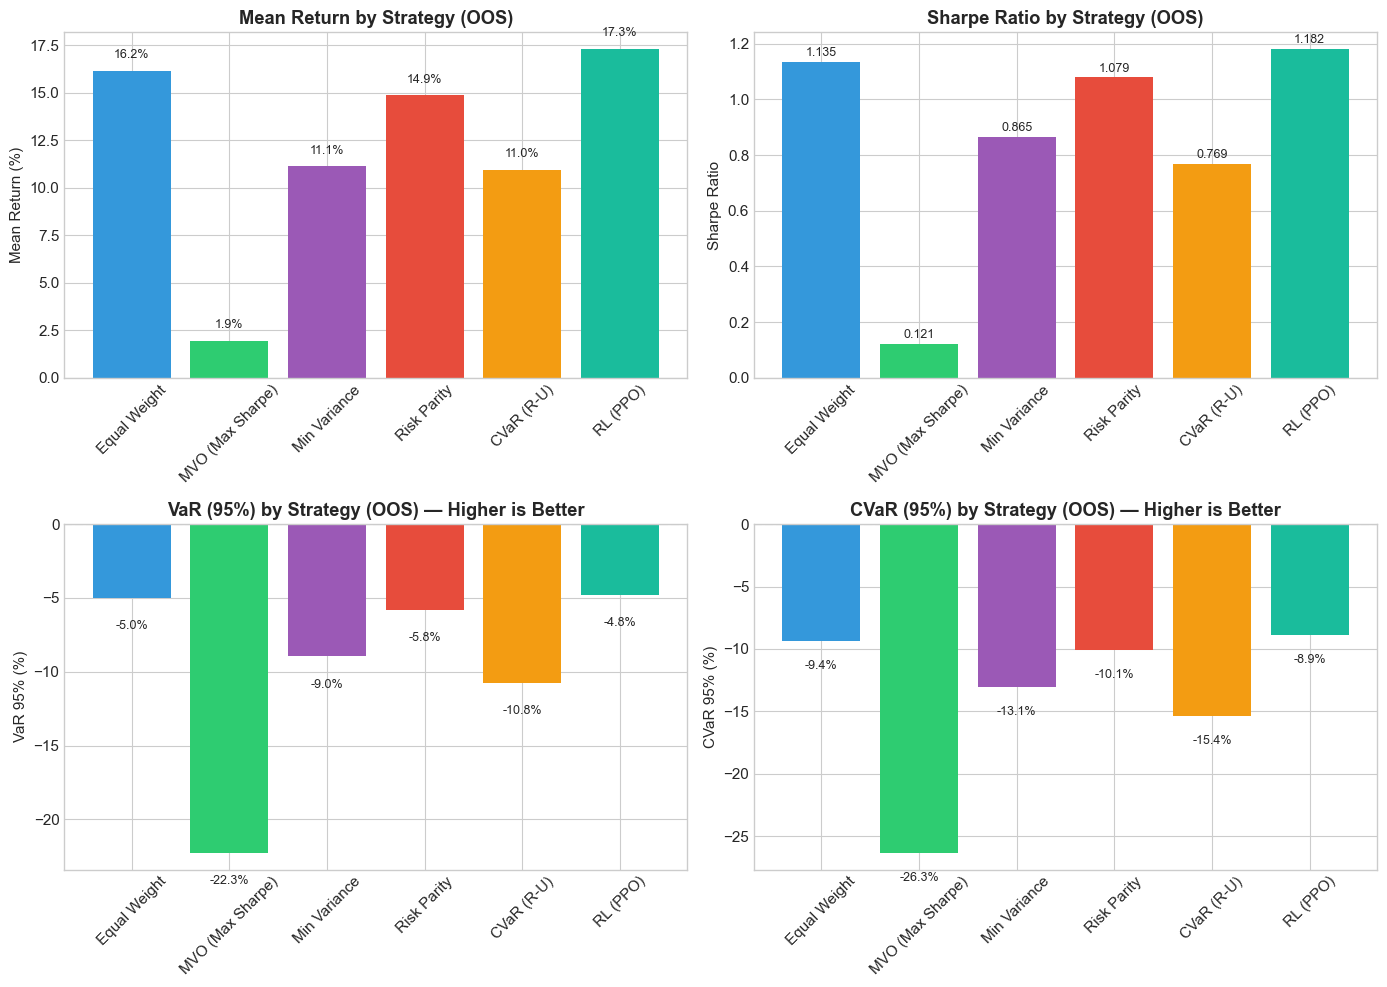

In [55]:
# Bar chart: Mean Return comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = list(mc_results.keys())
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']

# 1. Mean Return
ax1 = axes[0, 0]
returns = [mc_results[s].mean_return * 100 for s in strategies]
bars1 = ax1.bar(strategies, returns, color=colors)
ax1.set_ylabel('Mean Return (%)')
ax1.set_title('Mean Return by Strategy (OOS)', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, returns):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Sharpe Ratio
ax2 = axes[0, 1]
sharpes = [mc_results[s].mean_return / mc_results[s].std_return 
           if mc_results[s].std_return > 0 else 0 for s in strategies]
bars2 = ax2.bar(strategies, sharpes, color=colors)
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Sharpe Ratio by Strategy (OOS)', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, sharpes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 3. VaR (95%)
ax3 = axes[1, 0]
vars_95 = [mc_results[s].var_95 * 100 for s in strategies]
bars3 = ax3.bar(strategies, vars_95, color=colors)
ax3.set_ylabel('VaR 95% (%)')
ax3.set_title('VaR (95%) by Strategy (OOS) — Higher is Better', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars3, vars_95):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1.5, 
             f'{val:.1f}%', ha='center', va='top', fontsize=9)

# 4. CVaR (95%)
ax4 = axes[1, 1]
cvars_95 = [mc_results[s].cvar_95 * 100 for s in strategies]
bars4 = ax4.bar(strategies, cvars_95, color=colors)
ax4.set_ylabel('CVaR 95% (%)')
ax4.set_title('CVaR (95%) by Strategy (OOS) — Higher is Better', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars4, cvars_95):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1.5, 
             f'{val:.1f}%', ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

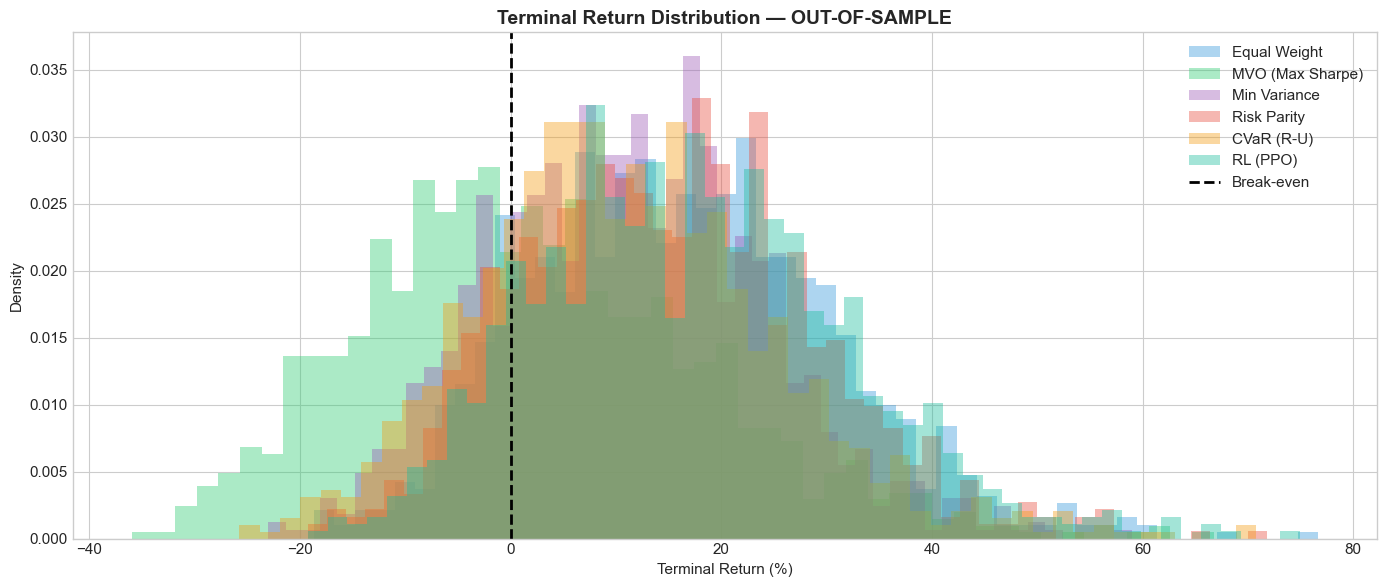

In [56]:
# Terminal Return Distribution
fig, ax = plt.subplots(figsize=(14, 6))

for i, (name, result) in enumerate(mc_results.items()):
    ax.hist(result.terminal_returns * 100, bins=50, alpha=0.4, 
            label=name, color=colors[i], density=True)

ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Break-even')
ax.set_xlabel('Terminal Return (%)')
ax.set_ylabel('Density')
ax.set_title('Terminal Return Distribution — OUT-OF-SAMPLE', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

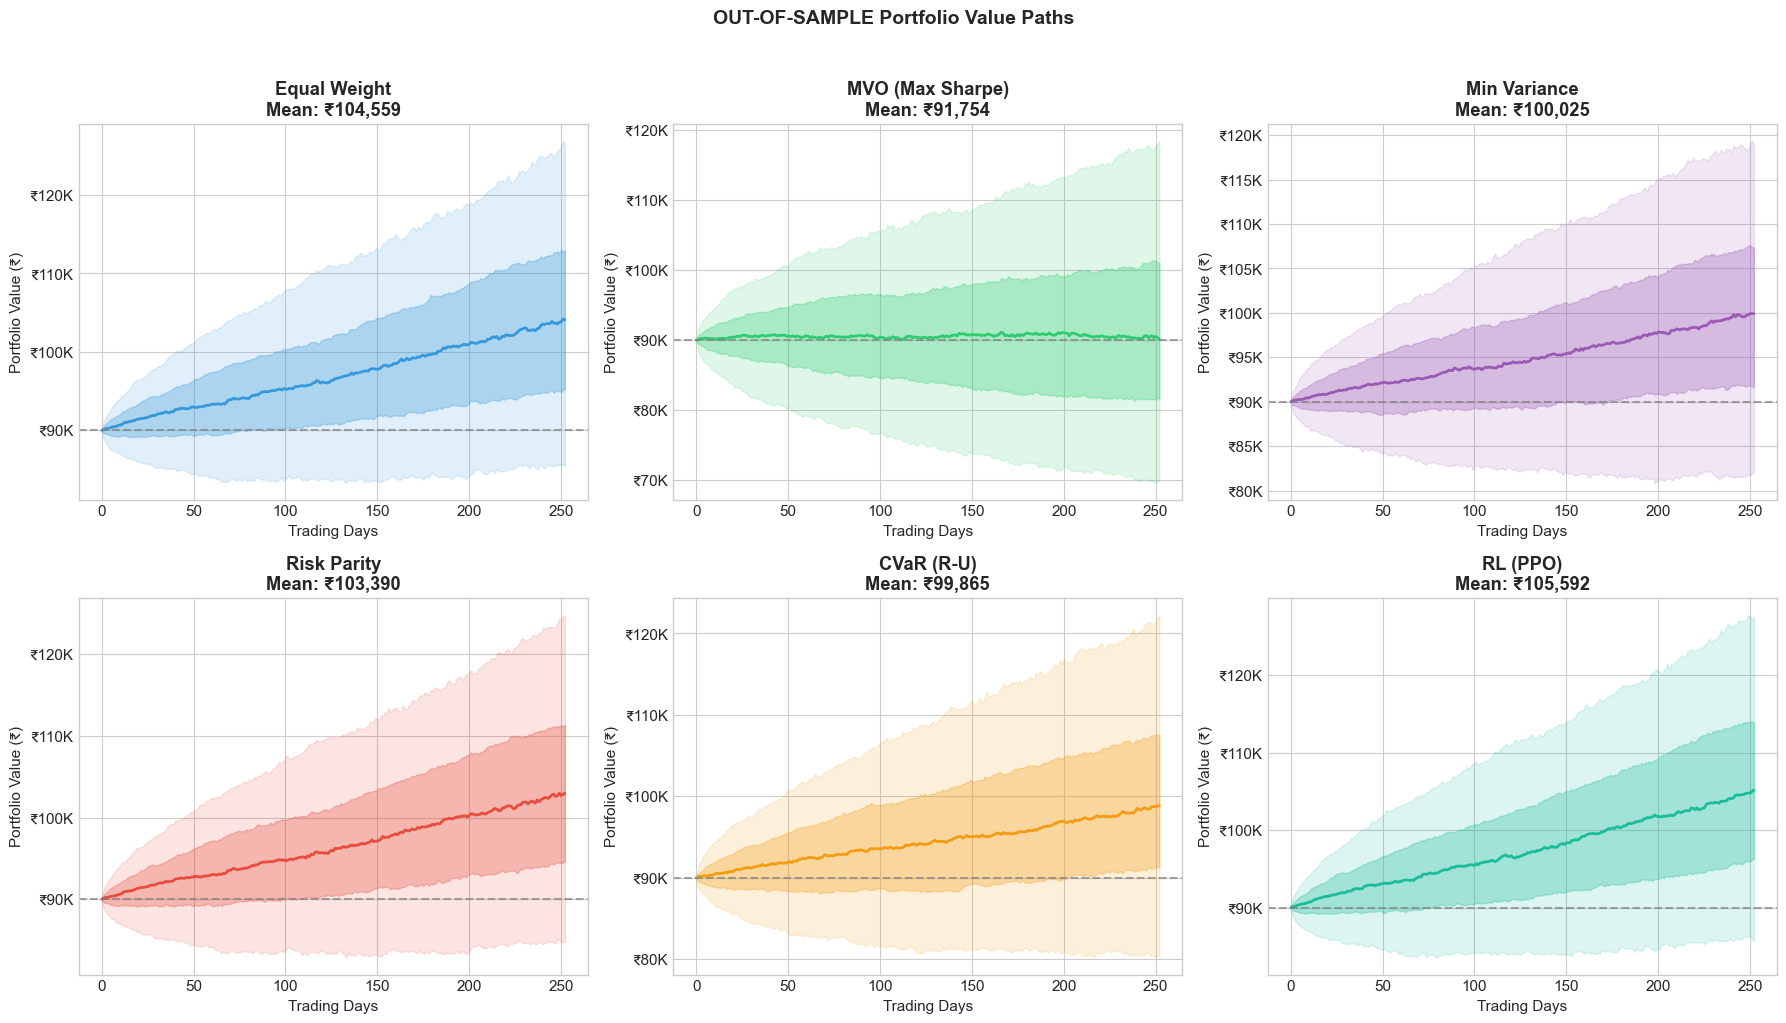

In [57]:
# Portfolio Value Paths (Fan Chart)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(mc_results.items()):
    ax = axes[idx]
    paths = result.portfolio_paths
    n_steps = paths.shape[0]
    x = np.arange(n_steps)
    
    pct5 = np.percentile(paths, 5, axis=1)
    pct25 = np.percentile(paths, 25, axis=1)
    pct50 = np.percentile(paths, 50, axis=1)
    pct75 = np.percentile(paths, 75, axis=1)
    pct95 = np.percentile(paths, 95, axis=1)
    
    ax.fill_between(x, pct5, pct95, alpha=0.15, color=colors[idx], label='5-95%')
    ax.fill_between(x, pct25, pct75, alpha=0.3, color=colors[idx], label='25-75%')
    ax.plot(x, pct50, color=colors[idx], linewidth=2, label='Median')
    ax.axhline(result.initial_value, color='gray', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{name}\nMean: ₹{result.mean_terminal_value:,.0f}', fontweight='bold')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Portfolio Value (₹)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/1000:.0f}K'))

plt.suptitle('OUT-OF-SAMPLE Portfolio Value Paths', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 12. Final Ranking

In [58]:
# Rank strategies by each metric
ranking_df = comparison_df[["Mean Return", "Sharpe Ratio", "VaR (95%)", "CVaR (95%)"]].copy()

# Higher is better for all metrics
ranks = {}
for col in ranking_df.columns:
    ranks[col] = ranking_df[col].rank(ascending=False).astype(int)

ranks_df = pd.DataFrame(ranks)
ranks_df["Avg Rank"] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values("Avg Rank")

print("=" * 80)
print("FINAL RANKING — OUT-OF-SAMPLE TEST (1 = Best)")
print("=" * 80)
display(ranks_df)

print("\n🏆 WINNER:", ranks_df.index[0])
print(f"   Average Rank: {ranks_df.iloc[0]['Avg Rank']:.2f}")

FINAL RANKING — OUT-OF-SAMPLE TEST (1 = Best)


,Mean Return,Sharpe Ratio,VaR (95%),CVaR (95%),Avg Rank
Strategy,,,,,
RL (PPO),1,1,1,1,1.0
Equal Weight,2,2,2,2,2.0
Risk Parity,3,3,3,3,3.0
Min Variance,4,4,4,4,4.0
CVaR (R-U),5,5,5,5,5.0
MVO (Max Sharpe),6,6,6,6,6.0



🏆 WINNER: RL (PPO)
   Average Rank: 1.00


## 13. Summary Report

In [59]:
print("=" * 100)
print("OUT-OF-SAMPLE COMPARISON REPORT: RL vs CLASSICAL BASELINES (FAIR COMPARISON)")
print("=" * 100)

print(f"""
EXPERIMENT SETUP
----------------
• Assets: {n_assets} Indian stocks
• Training Data (IN-SAMPLE): {len(train_price_df)} days ({train_price_df.index[0].strftime('%Y-%m-%d')} to {train_price_df.index[-1].strftime('%Y-%m-%d')})
• Test Data (OOS): {len(price_df)} days ({price_df.index[0].strftime('%Y-%m-%d')} to {price_df.index[-1].strftime('%Y-%m-%d')})
• Initial Capital: ₹{capital_config.investable_capital:,.0f}
• Monte Carlo: {N_PATHS} paths × {N_STEPS} days
• Noise Model: {NOISE_TYPE}

⚠ FAIR COMPARISON — ALL STRATEGIES USE IN-SAMPLE DATA FOR FITTING:
  - RL (PPO): Trained on 2018-2021 data
  - MVO, MinVar, Risk Parity, CVaR: Fitted on 2018-2021 data
  - Equal Weight: No fitting needed (1/N allocation)
  - Test data (2022-present) is unseen by ALL strategies!

STRATEGIES COMPARED
-------------------
1. Equal Weight     — Naive 1/N allocation (no fitting)
2. MVO (Max Sharpe) — Markowitz optimization (fitted on IN-SAMPLE 2018-2021)
3. Min Variance     — Global minimum variance (fitted on IN-SAMPLE 2018-2021)
4. Risk Parity      — Equal risk contribution (fitted on IN-SAMPLE 2018-2021)
5. CVaR (R-U)       — Rockafellar–Uryasev CVaR (fitted on IN-SAMPLE 2018-2021)
6. RL (PPO)         — Trained on IN-SAMPLE 2018-2021 with ROBUST INFERENCE

ROBUST INFERENCE CONFIG (for RL)
--------------------------------
• Start-step ensemble: {ROBUST_CONFIG['start_steps']}
• Last-K smoothing: {ROBUST_CONFIG['last_k']}
• Weight cap: {ROBUST_CONFIG['cap']*100:.0f}%
• Weight floor: {ROBUST_CONFIG['floor']*100:.0f}%
• Softmax temperature: {ROBUST_CONFIG['temperature']}
""")

print("KEY FINDINGS (OUT-OF-SAMPLE)")
print("-" * 40)

for metric in ["Mean Return", "Sharpe Ratio", "VaR (95%)", "CVaR (95%)"]:
    best_strategy = comparison_df[metric].idxmax()
    best_value = comparison_df.loc[best_strategy, metric]
    rl_value = comparison_df.loc["RL (PPO)", metric]
    rl_rank = int(ranks_df.loc["RL (PPO)", metric])
    
    print(f"• {metric}: Best = {best_strategy} ({best_value:.2%}), RL rank = #{rl_rank}")

print(f"""
OVERALL RANKING (OUT-OF-SAMPLE — FAIR COMPARISON)
-------------------------------------------------
""")

for i, (strategy, row) in enumerate(ranks_df.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{medal} #{i} {strategy:20s} (Avg Rank: {row['Avg Rank']:.2f})")

print("\n" + "=" * 100)
print("END OF OUT-OF-SAMPLE REPORT (FAIR COMPARISON)")
print("=" * 100)

OUT-OF-SAMPLE COMPARISON REPORT: RL vs CLASSICAL BASELINES (FAIR COMPARISON)

EXPERIMENT SETUP
----------------
• Assets: 25 Indian stocks
• Training Data (IN-SAMPLE): 987 days (2018-01-01 to 2021-12-30)
• Test Data (OOS): 1012 days (2022-01-03 to 2026-02-04)
• Initial Capital: ₹90,000
• Monte Carlo: 1000 paths × 252 days
• Noise Model: block_bootstrap

⚠ FAIR COMPARISON — ALL STRATEGIES USE IN-SAMPLE DATA FOR FITTING:
  - RL (PPO): Trained on 2018-2021 data
  - MVO, MinVar, Risk Parity, CVaR: Fitted on 2018-2021 data
  - Equal Weight: No fitting needed (1/N allocation)
  - Test data (2022-present) is unseen by ALL strategies!

STRATEGIES COMPARED
-------------------
1. Equal Weight     — Naive 1/N allocation (no fitting)
2. MVO (Max Sharpe) — Markowitz optimization (fitted on IN-SAMPLE 2018-2021)
3. Min Variance     — Global minimum variance (fitted on IN-SAMPLE 2018-2021)
4. Risk Parity      — Equal risk contribution (fitted on IN-SAMPLE 2018-2021)
5. CVaR (R-U)       — Rockafellar–U